In [60]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import geometry as Geom
import environment as Env
import ray as Ray
import simulation as Sim

In [61]:
reload(Geom)
reload(Env)
reload(Ray)
reload(Sim)

<module 'simulation' from '/Users/anatole/Documents/GitHub/ray-tracer/simulation.py'>

In [62]:
# Source setup
source = np.array([0., 0.])
angle = -0.5

In [152]:
reload(Env)

# floor = lambda x: -550 * np.ones_like(x)
floor = lambda x: -0.27 * x - 500
floor = lambda x: np.maximum(-1 * np.exp(0.0005 * x) - 500, -1500 + 0.02*x)
floor = lambda x: -500 * np.sin(0.001 * x) - 750
ceiling = lambda x: 0 * np.ones_like(x)

env = Env.Environment2D(
    floor=floor,
    ceiling=ceiling
)

In [165]:
reload(Ray)

ray = Ray.Ray2D(env, source, angle)
ray.propagate(verbose=True)

DEBUG: Ground rebound. New dir: [0.1127138  0.16448611]
DEBUG: Surface rebound. New dir: [ 0.06985395 -0.1       ]
DEBUG: Ground rebound. New dir: [-0.04710422  0.14305327]
DEBUG: Backpropagation


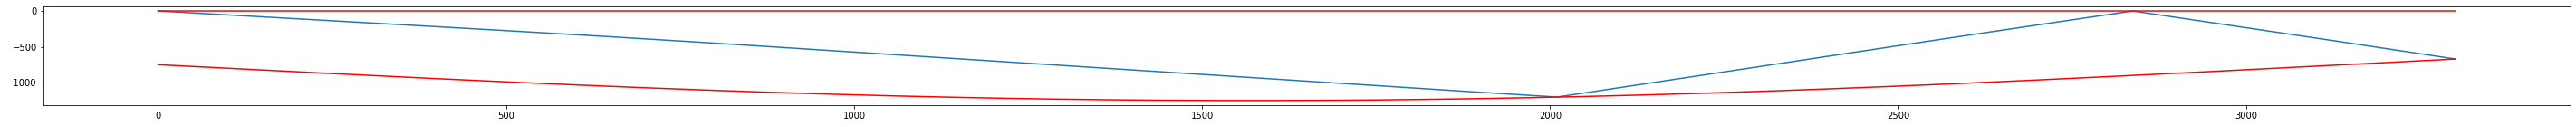

In [166]:
plt.figure(figsize=(50, 2))
plt.plot(ray.XZ[:,0], ray.XZ[:,1])
plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
plt.show()